<a href="https://colab.research.google.com/github/Chaitra-B-V/Univariate-TimeSeries-forecasting-with-ExogenousVariables-Using-Pycaret/blob/main/UTSwithExogenousVariable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
START_DATE = "2020-04-01"
END_DATE = "2021-08-18"
TRAIN_TEST_SPLIT = 0.8

PREDICTION_START_DATE = "2021-05-10"
PREDICTION_END_DATE = "2021-08-18"

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
sns.set()

warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

In [ ]:
!pip install yfinance

In [5]:
import yfinance
ticker_dict = {
    "Unilever": "HINDUNILVR.NS",
    "P&G": "PGHH.NS",
    "Nestle": "NESTLEIND.NS",
    "Diageo": "MCDOWELL-N.NS"
}
tickers = [value for key, value in ticker_dict.items()]

df = yfinance.download(" ".join(tickers), start = START_DATE,
    end = END_DATE, interval = "1d", group_by = 'ticker', auto_adjust = True, treads = True)
df_orig = df.copy()

# Day close and drop others
for key, value in ticker_dict.items():
    df[key]=df[value].Close[:]
    del df[value]

# Set frequency on business days of the week and Forward fill
df = df.asfreq('b').fillna(method='ffill')
df.shape

### Splitting the Data
train_length = int(len(df) * TRAIN_TEST_SPLIT)
df_train = df.iloc[:train_length]
df_test = df.iloc[train_length:]

[*********************100%***********************]  4 of 4 completed


In [6]:
from statsmodels.tsa.arima_model import ARIMA

def arima_util(model_name, model_config, enforce_stationarity=False):

    model_output = {}
    for key in ticker_dict.keys():
        model_output[key] = {}

        fit_model = None
        predictions_df = None
        try:
            model = ARIMA(df_train[key], order=model_config)
            fit_model = model.fit()
            predictions_df = fit_model.predict(start=min(df_test.index), end=max(df_test.index))
            model_output[key]["isFit"] = True
        except Exception as e:
            print(f"Exception Occurred, while training {key} : ", e.__class__)
            print(e)
            model_output[key]["isFit"] = False

        model_output[key]["model"] = fit_model
        model_output[key]["predictions"] = predictions_df

    return model_output

def plt_predictions(df_actuals, model_predictions, title):
    fig, axs = plt.subplots(2, 2, figsize=(30, 20))
    fig.suptitle(title, size=32)
    row = 0
    col = 0
    for key in ticker_dict.keys():
        predictions = model_predictions[key]
        ax = axs[row, col]
        actuals = df_actuals[key]
        minn = actuals.min()
        maxx = actuals.max()
        ax.set_ylim(minn - minn * 0.1, maxx + maxx * 0.1)
        if predictions["isFit"]:
            ax.plot(predictions["predictions"], color="red")
        ax.plot(df_actuals[key], color="blue")
        ax.set_title(key, size=24)
        col += 1
        if(col == 2):
            row += 1
            col = 0

    plt.show()

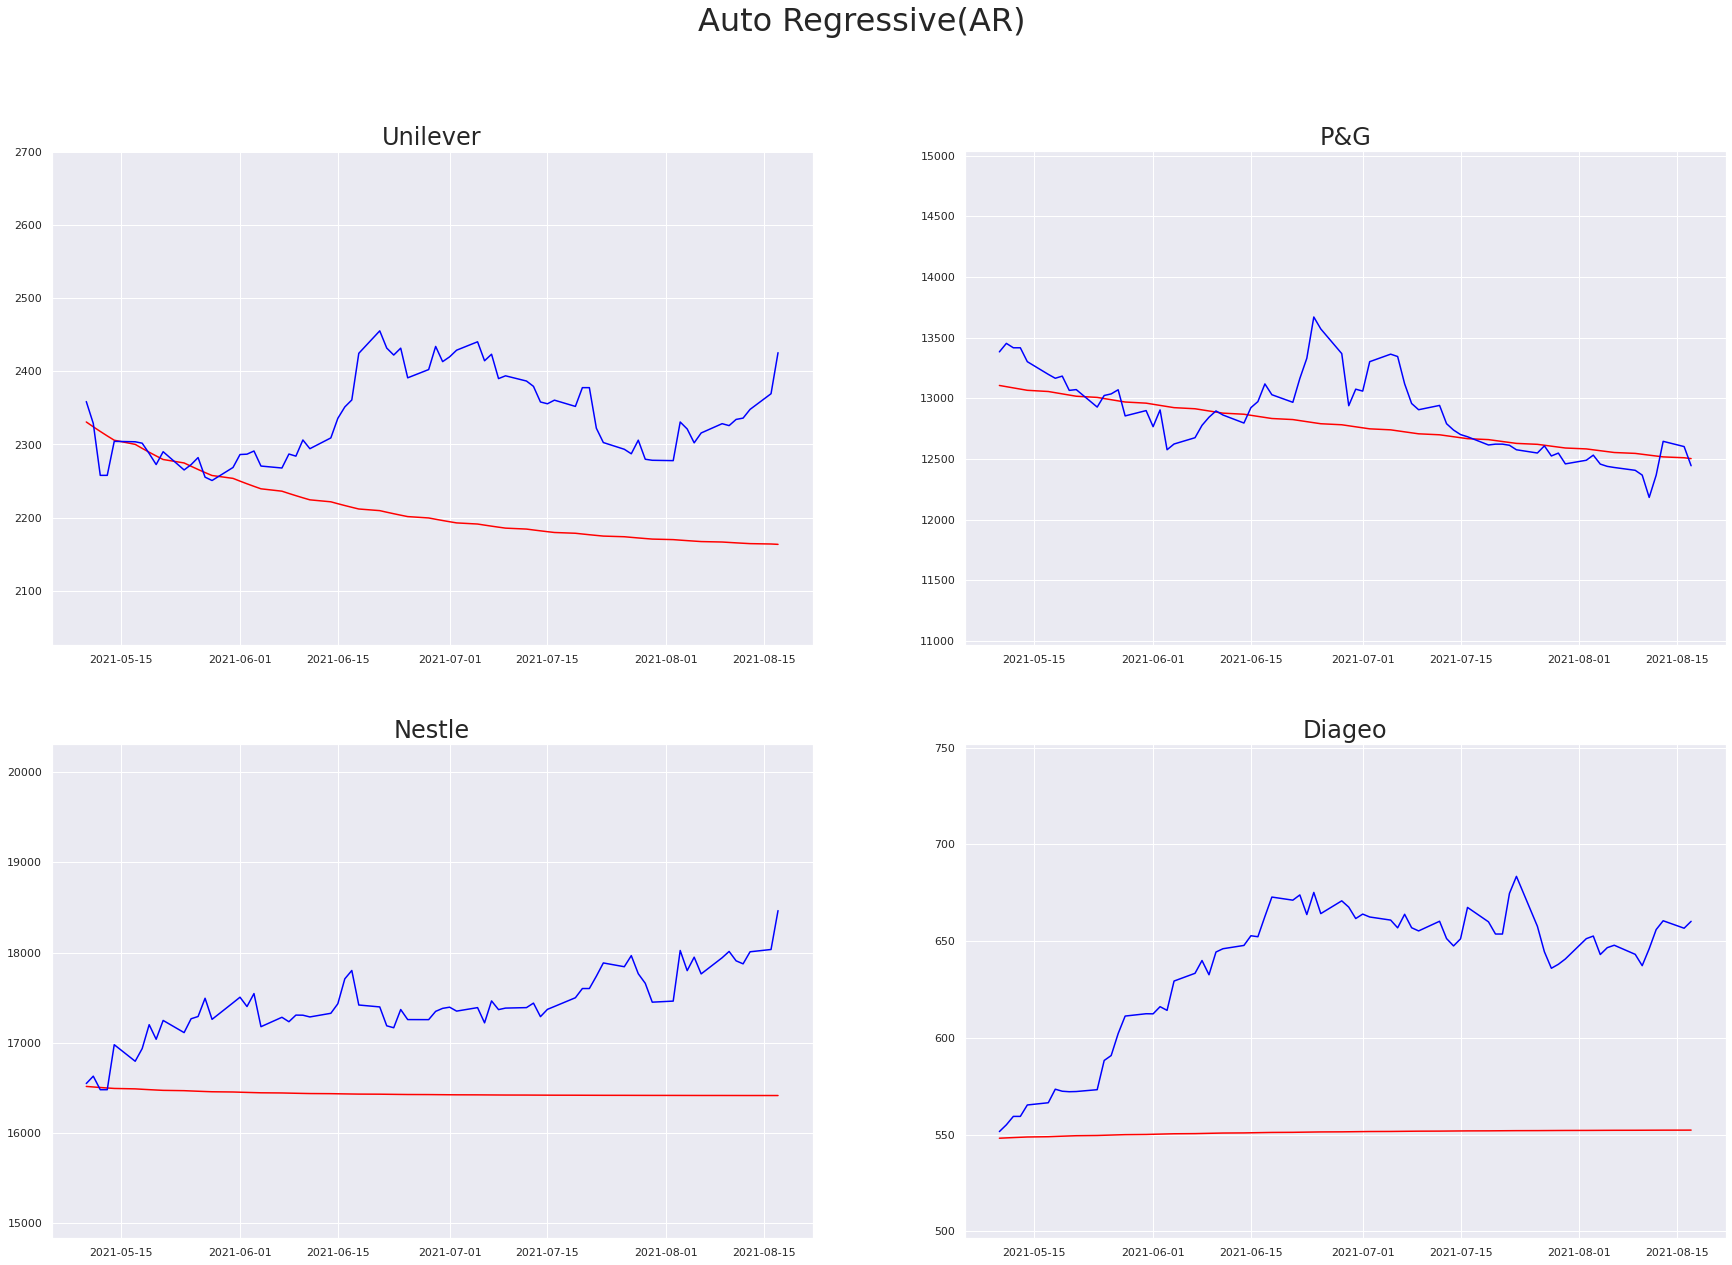

In [7]:
auto_regressive_models = arima_util("Auto Regressive", (1, 0, 0))
plt_predictions(df_test[PREDICTION_START_DATE:PREDICTION_END_DATE], auto_regressive_models, "Auto Regressive(AR)")

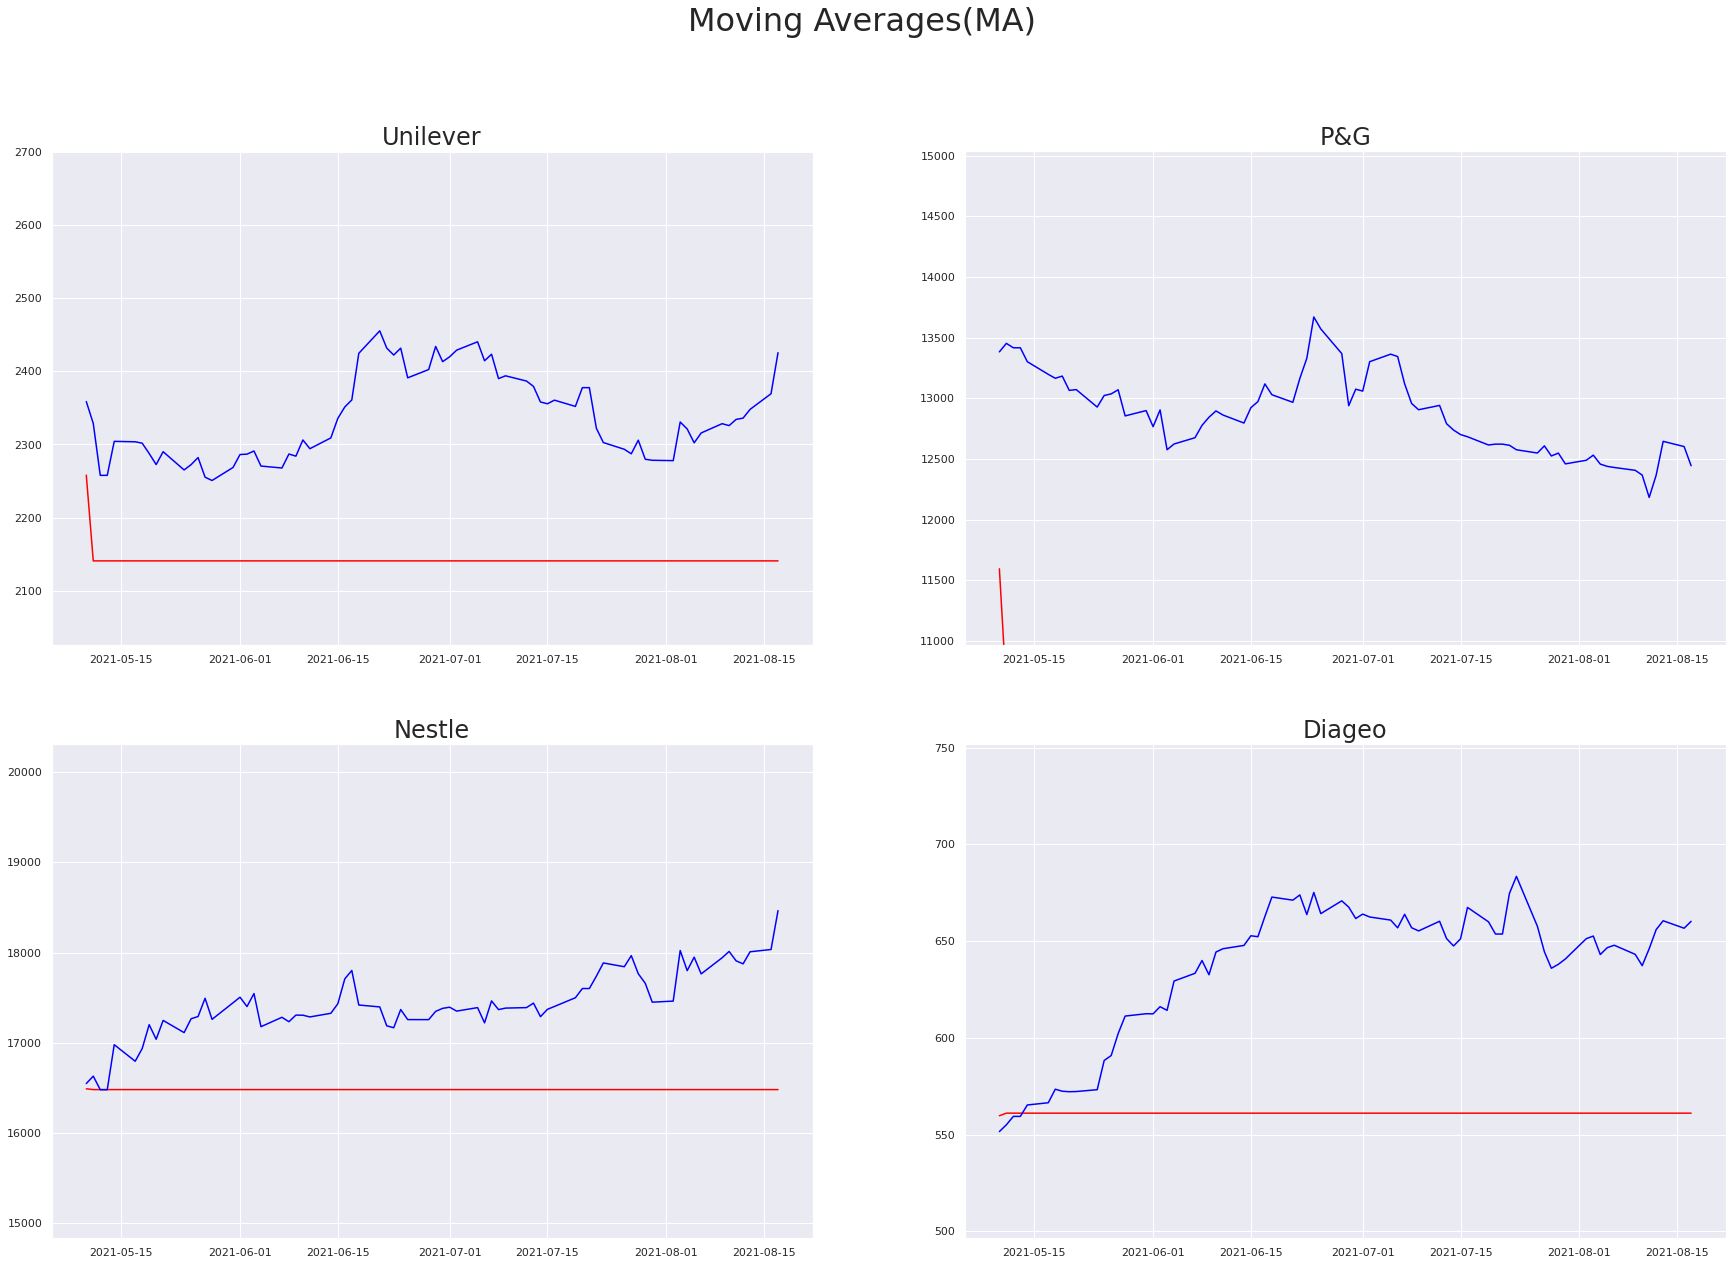

In [8]:
moving_averages_models = arima_util("Moving Averages(MA)", (0, 0, 1))
plt_predictions(df_test[PREDICTION_START_DATE:PREDICTION_END_DATE], moving_averages_models, "Moving Averages(MA)")

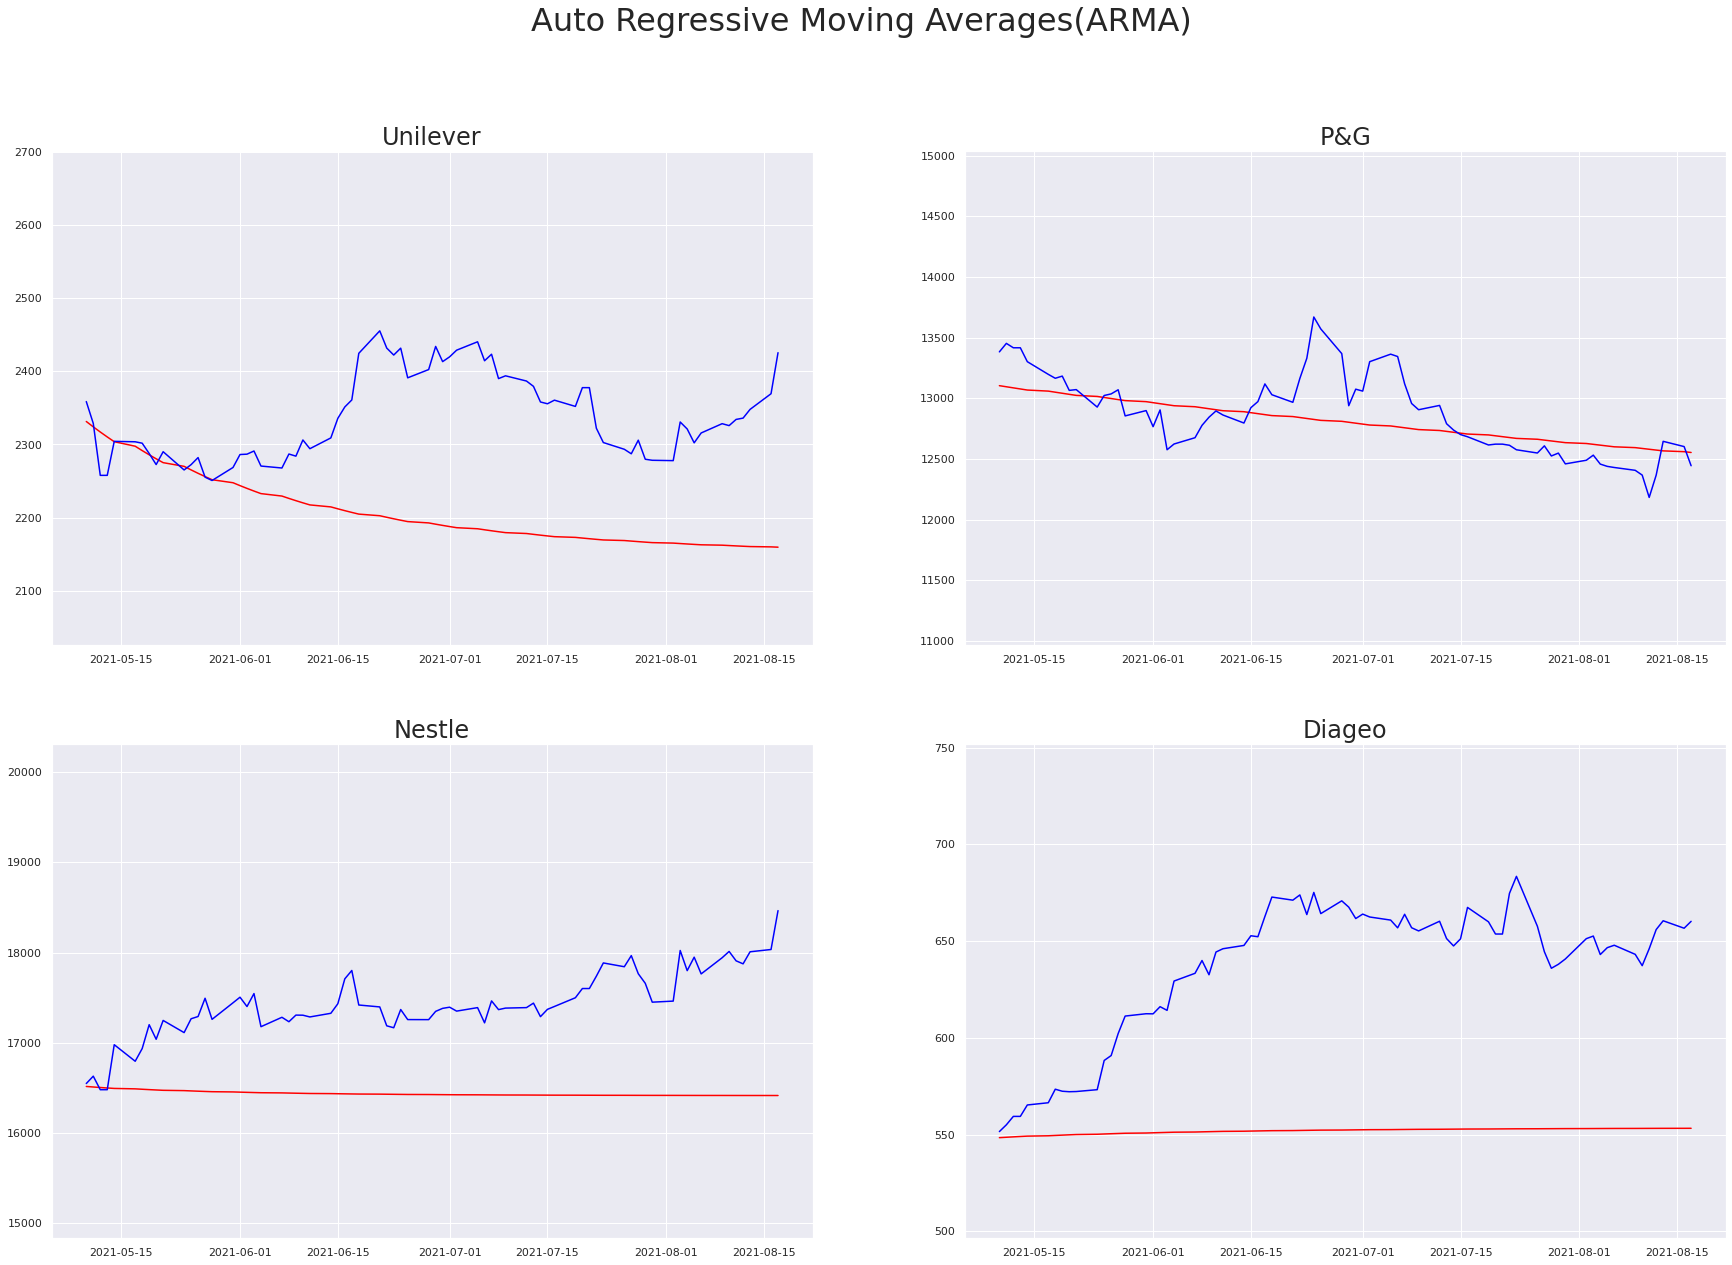

In [9]:
arma_models = arima_util("ARMA", (1, 0, 1))
plt_predictions(df_test[PREDICTION_START_DATE:PREDICTION_END_DATE], arma_models, "Auto Regressive Moving Averages(ARMA)")


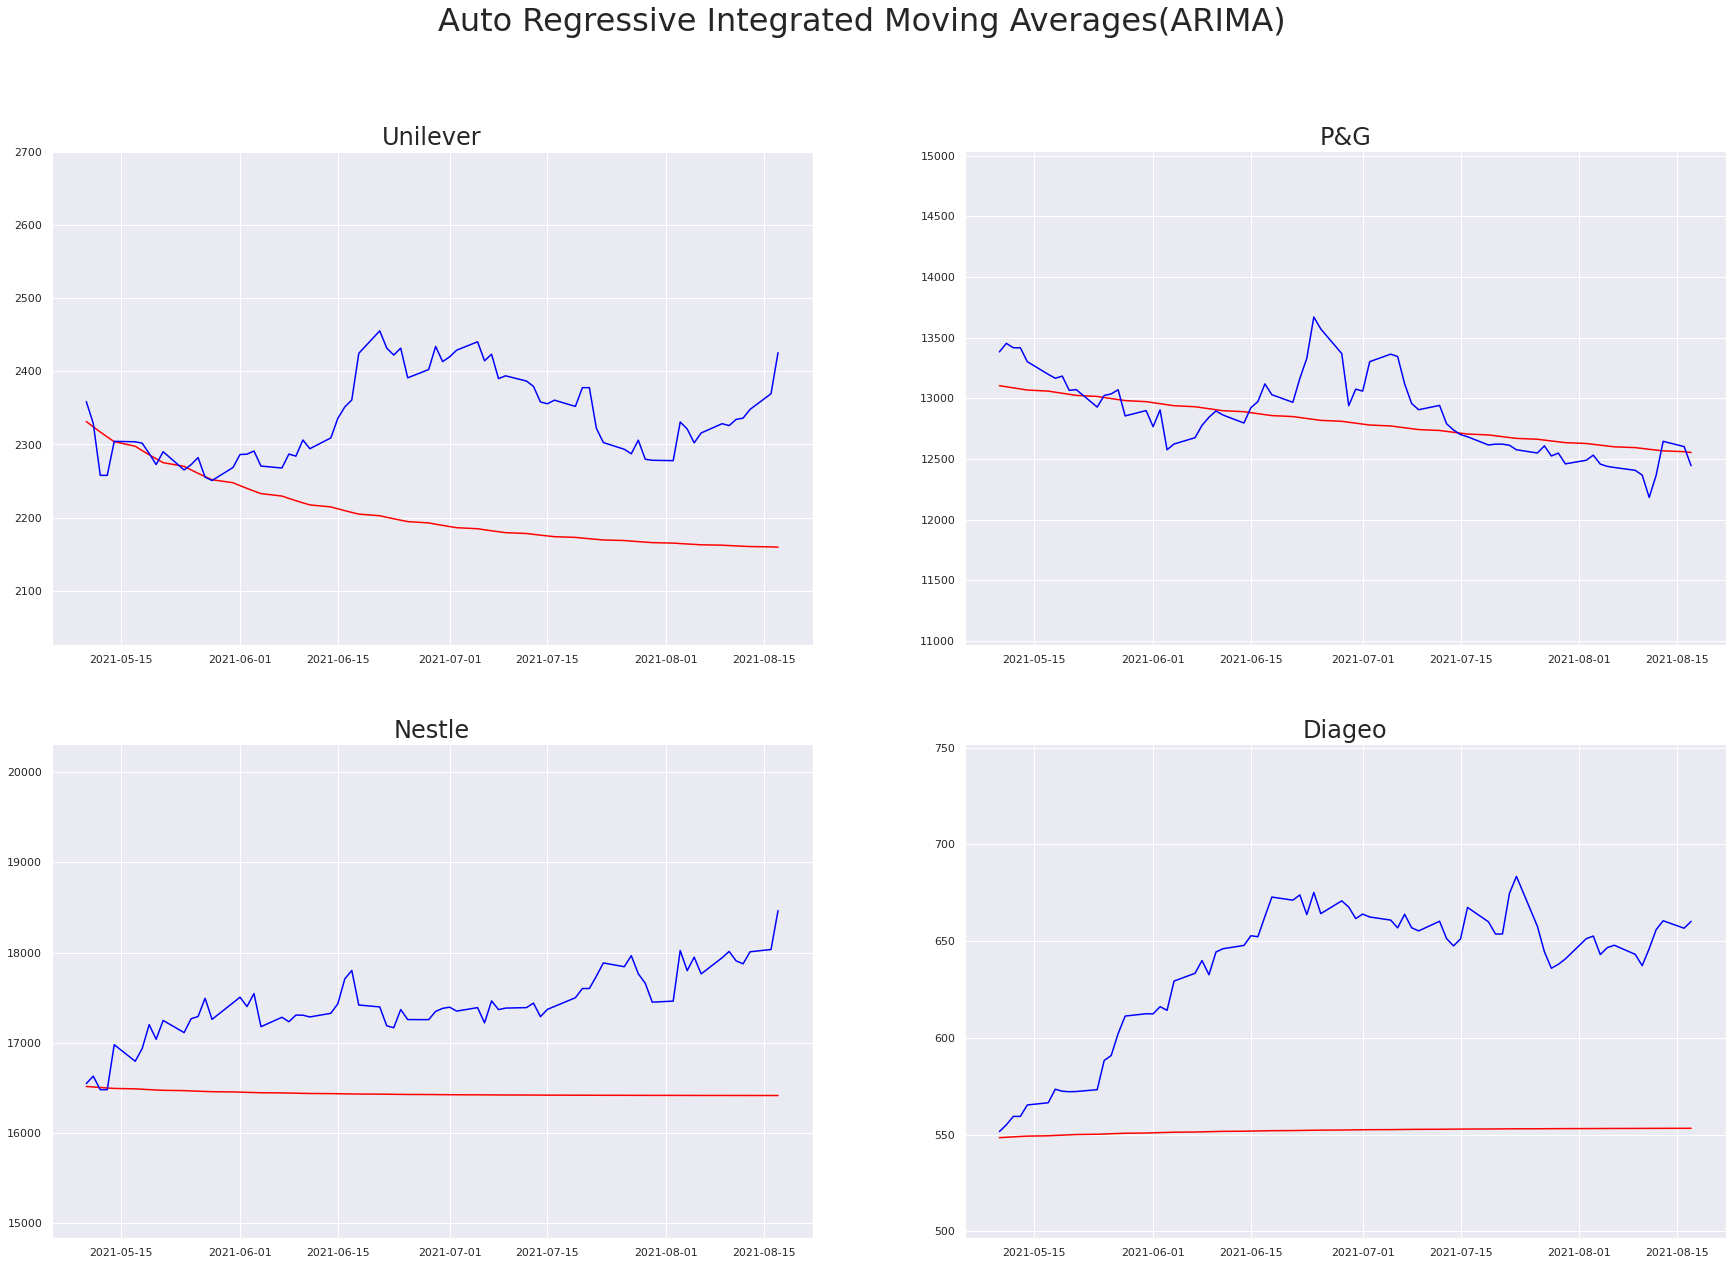

In [10]:
arima_models = arima_util("ARIMA", (1, 1, 1))
plt_predictions(df_test[PREDICTION_START_DATE:PREDICTION_END_DATE], arma_models, "Auto Regressive Integrated Moving Averages(ARIMA)")

In [11]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def sarima_util(model_name, model_config, seasonal_order, exogenous=False, enforce_stationarity=False):

    model_output = {}
    for key in ticker_dict.keys():
        print(f"Training {key}")
        model_output[key] = {}
        exog = None
        exog_test = None
        if(exogenous):
            keys = ticker_dict.copy()
            del keys["P&G"]
            exog_keys = keys.keys()
            exog = df_train[exog_keys]
            exog_test = df_test[PREDICTION_START_DATE:PREDICTION_END_DATE][exog_keys]

        fit_model = None
        predictions_df = None
        try:
            model = SARIMAX(df_train[key], order=model_config, seasonal_order=seasonal_order, exog=exog, enforce_stationarity=enforce_stationarity)
            fit_model = model.fit()
            predictions_df = fit_model.predict(start=min(df_test.index), end=max(df_test.index), exog=exog_test)
            model_output[key]["isFit"] = True
        except Exception as e:
            print("Exception Occurred, while training {key} : ", e.__class__)
            print(e)

            model_output[key]["isFit"] = False

        model_output[key]["model"] = fit_model
        model_output[key]["predictions"] = predictions_df

    return model_output

Training Unilever


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Training P&G
Training Nestle
Training Diageo


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


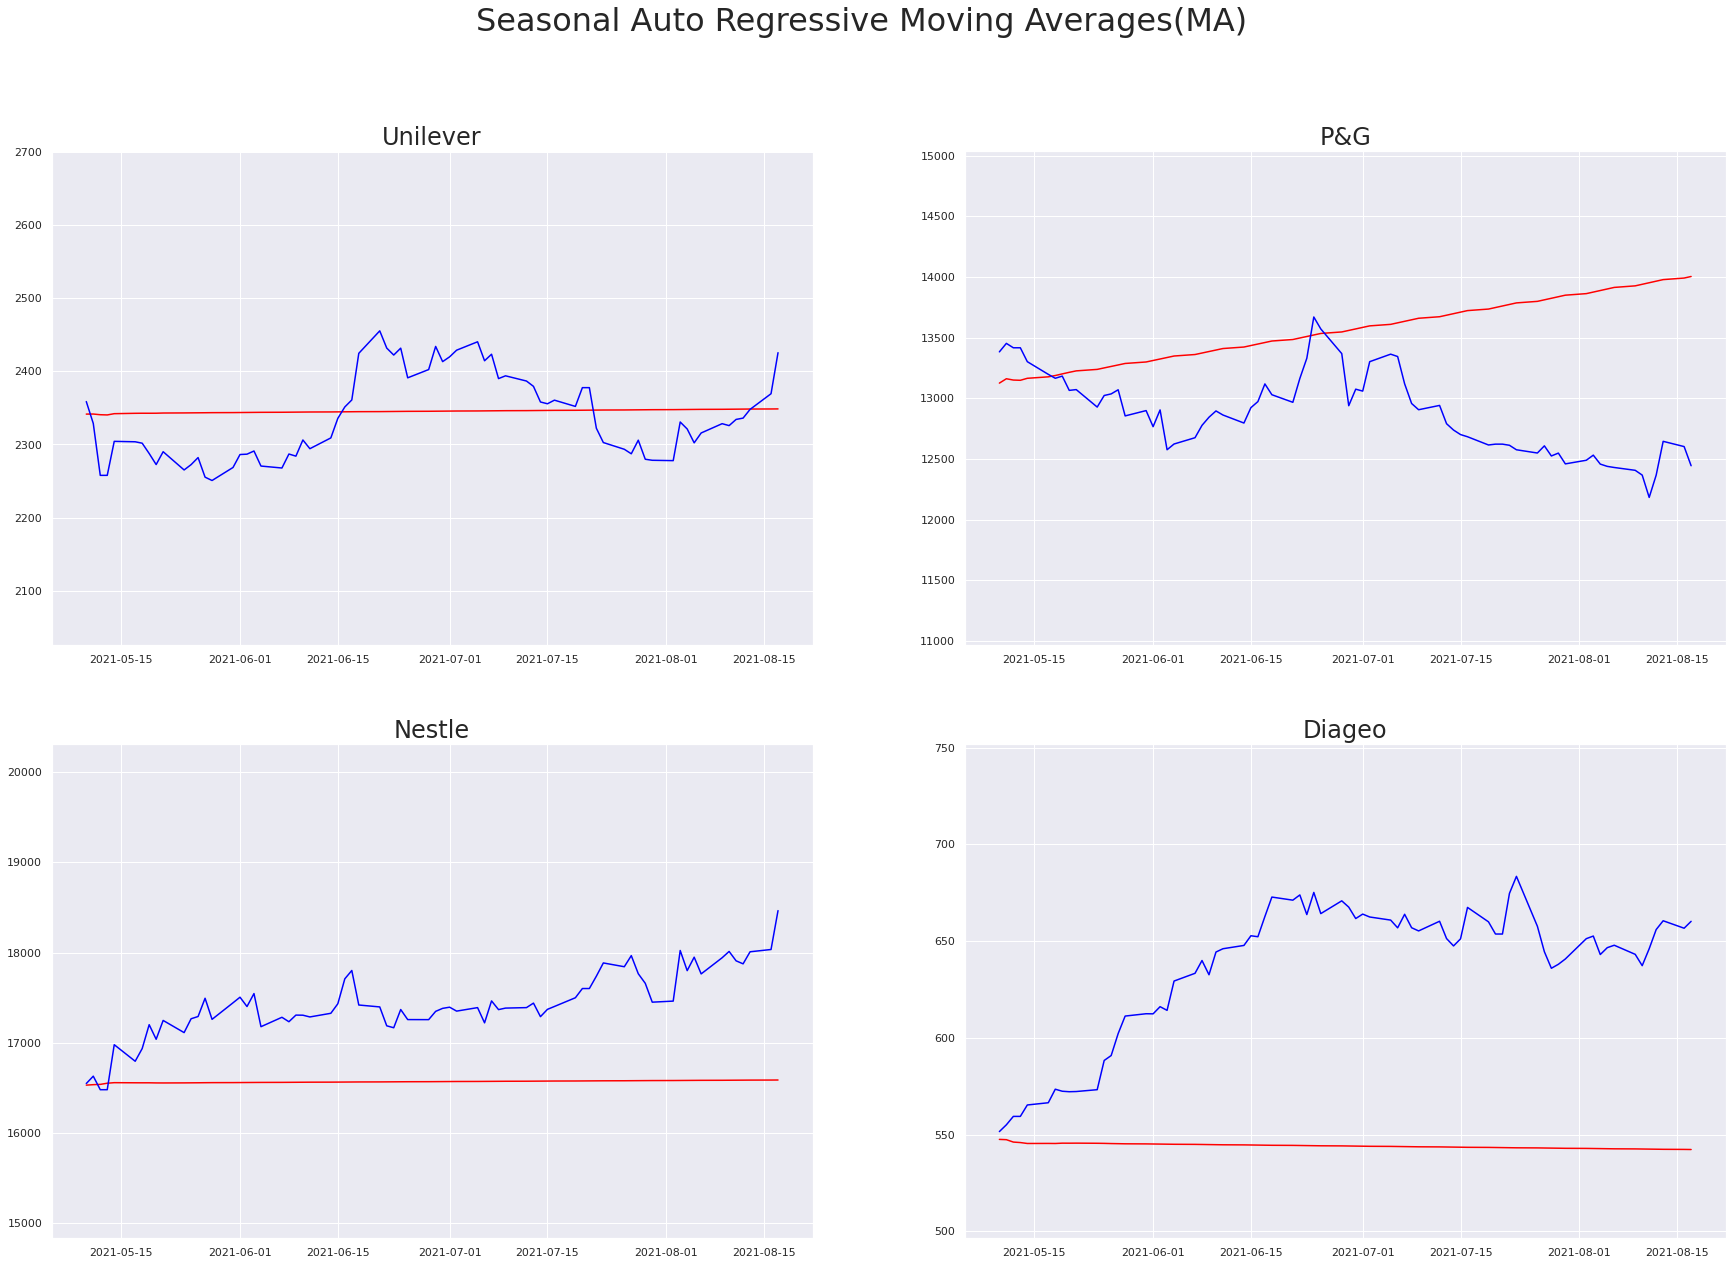

In [12]:
# Freeze
sarma_model = sarima_util("SARMA", (1, 0, 1), seasonal_order=(1, 0, 1, 5))
plt_predictions(df_test[PREDICTION_START_DATE:PREDICTION_END_DATE], sarma_model, "Seasonal Auto Regressive Moving Averages(MA)")

Training Unilever


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Training P&G


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Training Nestle


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Training Diageo


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


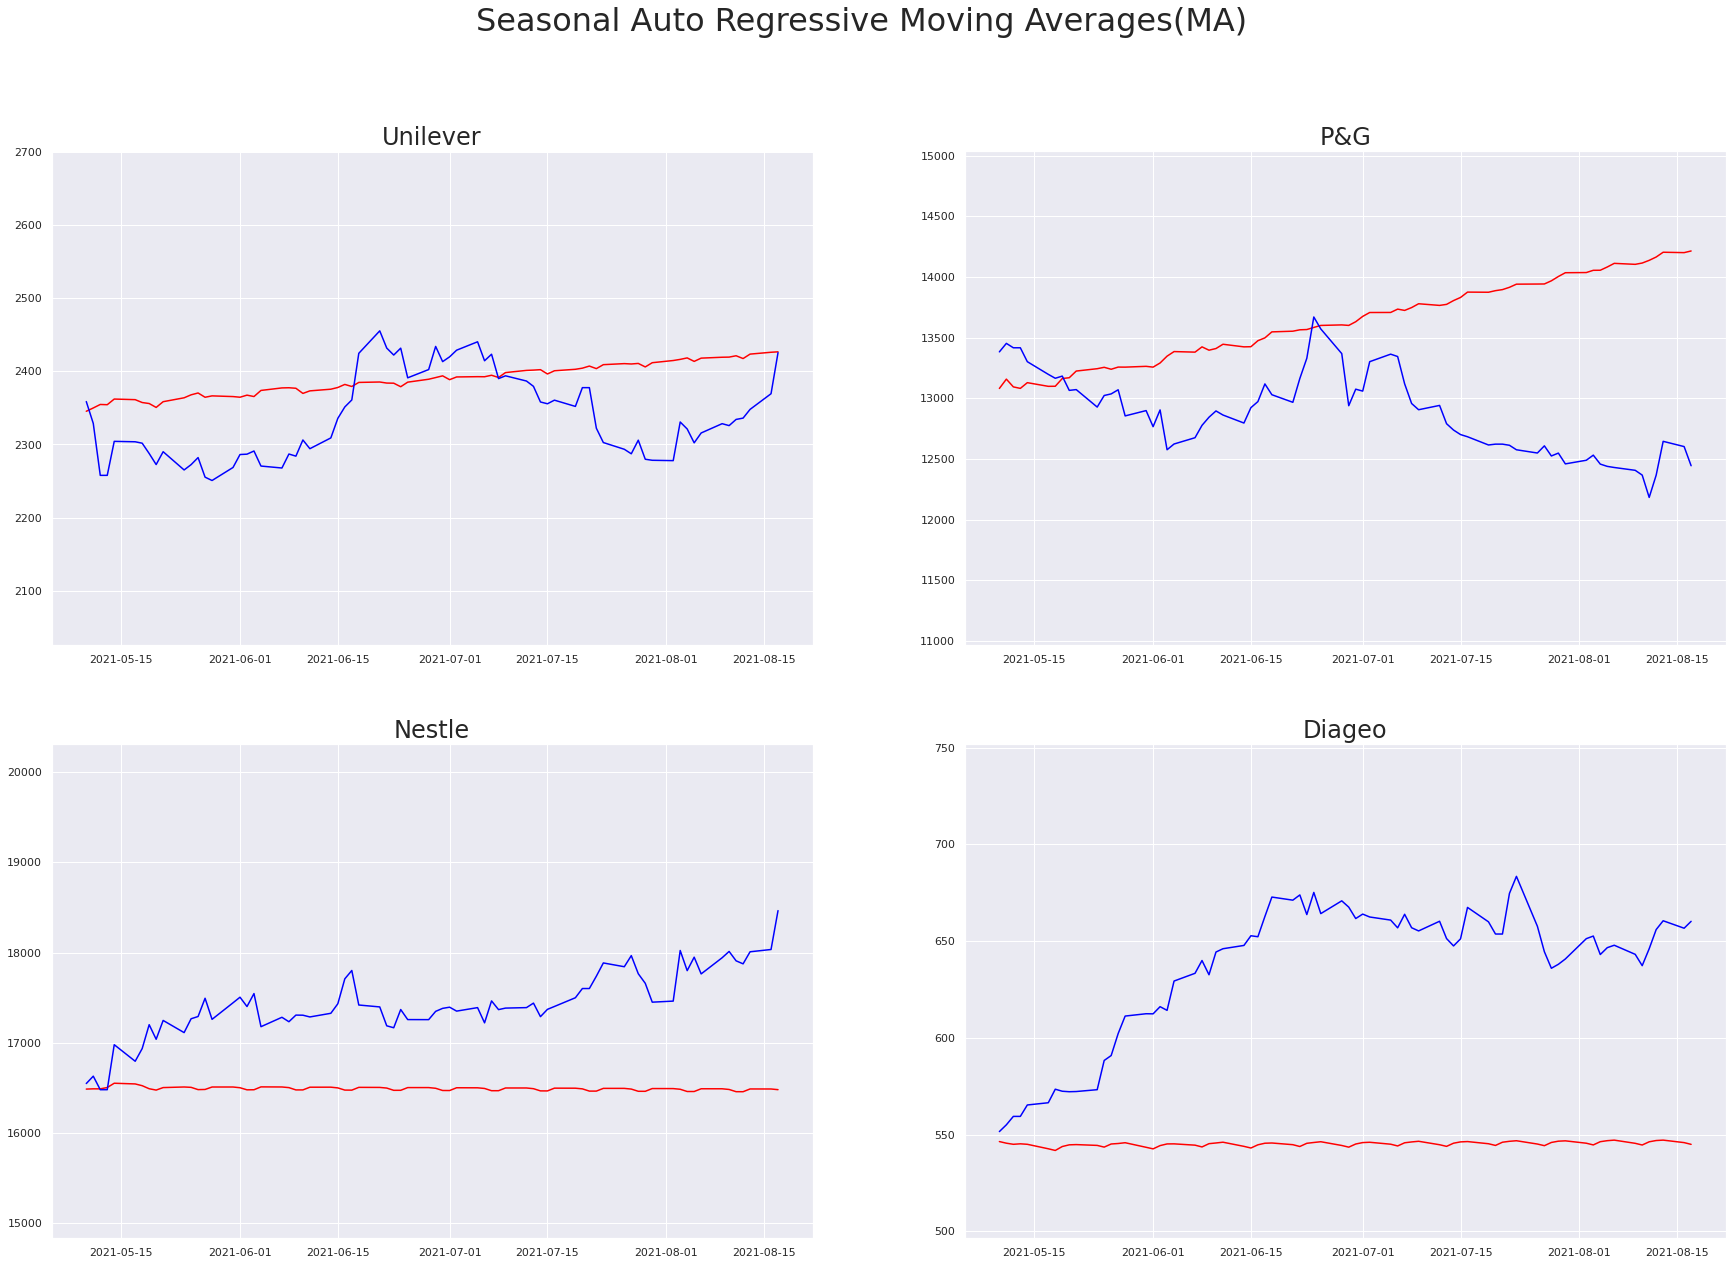

In [13]:
sarma_model = sarima_util("SARMA", (3, 1, 4), seasonal_order=(3, 1, 2, 5))
plt_predictions(df_test[PREDICTION_START_DATE:PREDICTION_END_DATE], sarma_model, "Seasonal Auto Regressive Moving Averages(MA)")

In [14]:
def exogenous_util(ticker, order, seasonal_order=None, enforce_stationarity=False):
    model_output = {}
    print(f"Training {ticker}")
    model_output = {}


    keys = ticker_dict.copy()
    del keys["P&G"]
    exog_keys = keys.keys()
    exog = df_train[exog_keys]
    exog_test = df_test[PREDICTION_START_DATE:PREDICTION_END_DATE][exog_keys]

    fit_model = None
    predictions_df = None
    try:
        model = SARIMAX(df_train[ticker], order=order, seasonal_order=seasonal_order, exog=exog, enforce_stationarity=enforce_stationarity)
        fit_model = model.fit()
        predictions_df = fit_model.predict(start=min(df_test.index), end=max(df_test.index), exog=exog_test)
        model_output["isFit"] = True
    except Exception as e:
        print("Exception Occurred, while training {key} : ", e.__class__)
        print(e)

        model_output["isFit"] = False

    model_output["model"] = fit_model
    model_output["predictions"] = predictions_df

    return model_output

In [15]:
armax_models = exogenous_util("P&G", (3, 0, 4), enforce_stationarity=True)
arimax_models = exogenous_util("P&G", (3, 1, 4), enforce_stationarity=True)

Training P&G


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Training P&G


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


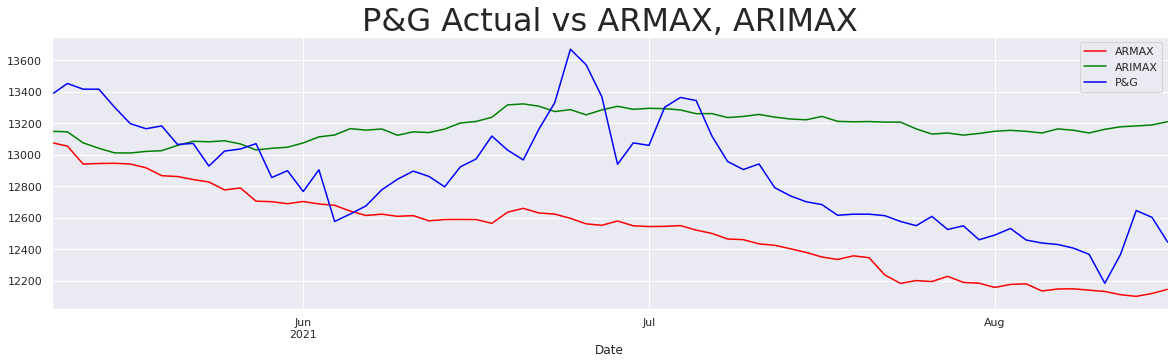

In [16]:

plt.figure(figsize=(20, 5))
armax_models["predictions"].plot(color="red", label="ARMAX")
arimax_models["predictions"].plot(color="green", label="ARIMAX")
df_test["P&G"].plot(color="blue")
plt.legend()
plt.title("P&G Actual vs ARMAX, ARIMAX", size=32)
plt.show()
# plt_predictions(df_test[PREDICTION_START_DATE:PREDICTION_END_DATE], armax_models, "Auto Regressive Moving Averages(MA)")

In [17]:
# Freeze
sarmax_model = exogenous_util("P&G", (3, 0, 4), seasonal_order=(3, 0, 2, 5), enforce_stationarity=True)
sarimax_model = exogenous_util("P&G", (3, 1, 4), seasonal_order=(3, 1, 2, 5), enforce_stationarity=True)
print(sarmax_model.keys())

Training P&G


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Training P&G


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


dict_keys(['isFit', 'model', 'predictions'])


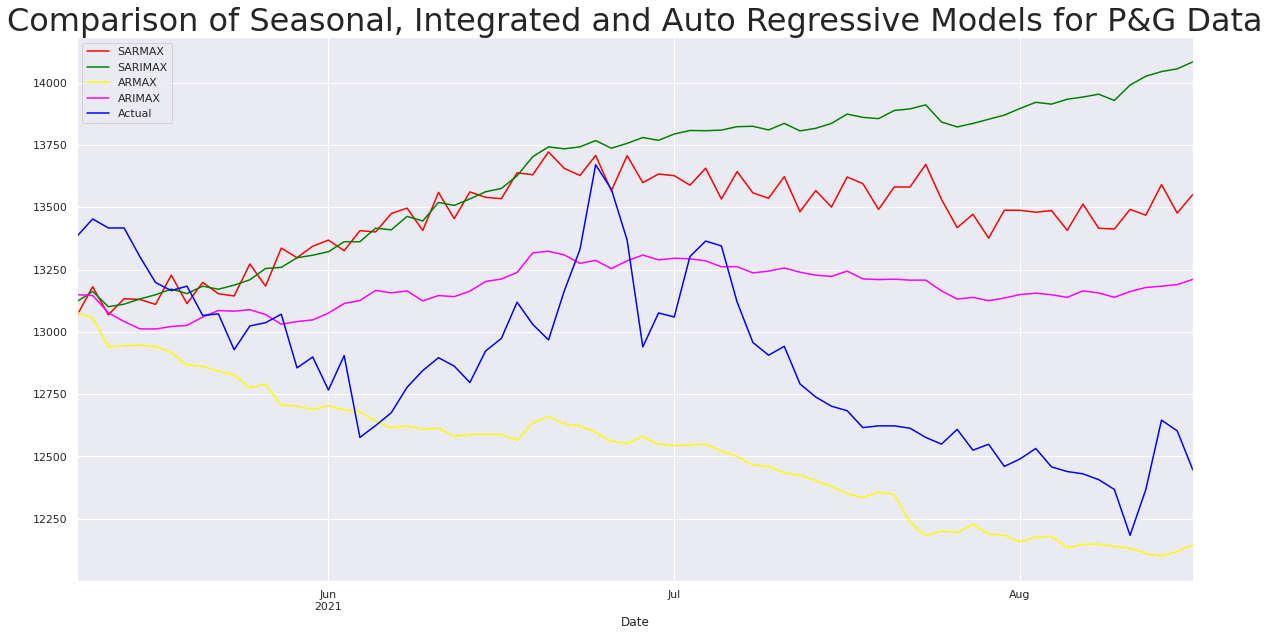

In [18]:

plt.figure(figsize=(20, 10))
sarmax_model["predictions"].plot(color="red", label="SARMAX")
sarimax_model["predictions"].plot(color="green", label="SARIMAX")
armax_models["predictions"].plot(color="yellow", label="ARMAX")
arimax_models["predictions"].plot(color="magenta", label="ARIMAX")
df_test["P&G"].plot(color="blue", label="Actual")
plt.legend()
plt.title("Comparison of Seasonal, Integrated and Auto Regressive Models for P&G Data", size=32)

plt.show()